<h3>Header</h3>

<h5>External Modules</h5>

In [1]:
# Utils
import matplotlib.pyplot as plt
#import pandas as pd
import random
import os
from PIL import Image, ImageOps
import numpy as np

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

<h5>Internal Modules</h5>

In [3]:
from dataset import pikfix_dataset, plot_data
from utils.degrade_image import degrade_image
from models.restoration_subnet import RestorationSubNet

<h5>Data path</h5>

In [4]:
# Define dataset root directory and it's csv file
data_dir = './data/'
csv_file = 'dataset.csv'

<h3>Main</h3>

Image degradation

(-0.5, 77.5, 90.5, -0.5)

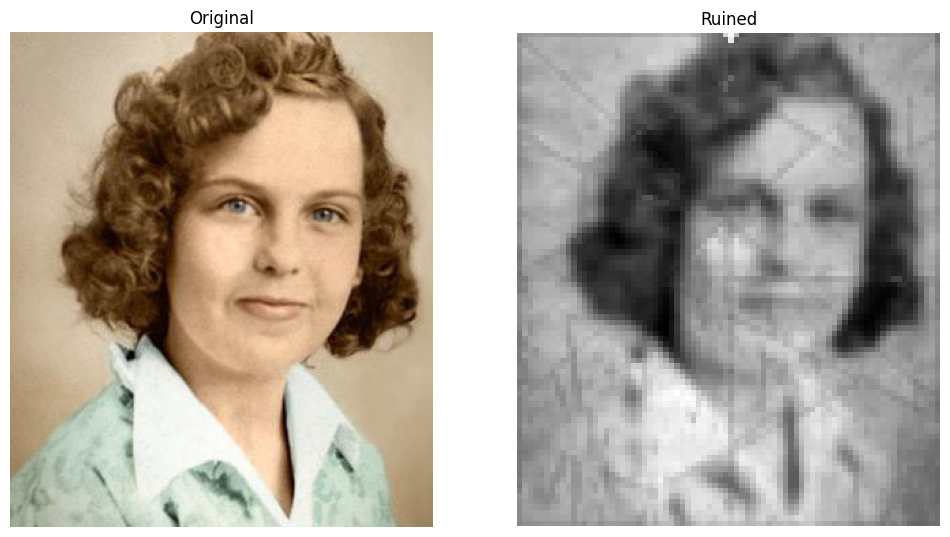

In [5]:
# Images and textures folder
images_folder = "data/res"
textures_folder = "data/textures"

# Select a random image
random_img = os.path.join(images_folder, random.choice(os.listdir(images_folder)))

# Degrade it
ruined_version = degrade_image(img=random_img, textures_folder=textures_folder, degradation_level=4, scaling_factor=4)

# Plot the result
fig, axs = plt.subplots(1, 2, figsize=(12,12))

plt.subplot(1,2,1)
plt.imshow(Image.open(random_img), cmap='gray')

plt.title(f'Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(ruined_version, cmap='gray')
plt.title(f'Ruined')
plt.axis('off')

#plt.savefig("version1.jpeg", bboh_inches='tight')

Import dataset

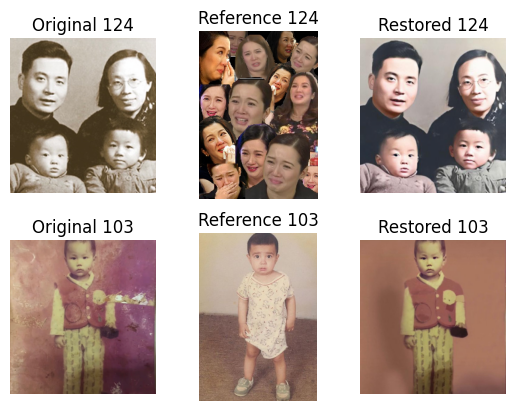

In [6]:
# Define the transformation to be applied on the images in the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Build dataset
dataset = pikfix_dataset.PikFixData(data_dir + csv_file, data_dir, transform)

# Plot some random samples
plot_data.plot_random_samples(2, dataset)

In [7]:
train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
it = iter(train_loader)

In [53]:
original, reference, restored = next(it)
original = original.to(torch.float32)

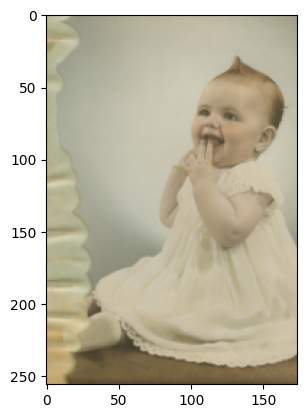

In [54]:
plot_data.imshow(original.squeeze())

In [28]:
from models import residual_dense

scale = 4 
num_features = 64 
growth_rate = 64 
num_blocks = 16 
num_layers = 8
weights_file = f"weights/rdn_x{scale}.pth" 
image_file = "data/res/5.png"

model = residual_dense.RDN(scale_factor=scale,
            num_channels=3,
            num_features=num_features,
            growth_rate=growth_rate,
            num_blocks=num_blocks,
            num_layers=num_layers)

state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

In [55]:
out = model(original)

(-0.5, 173.5, 255.5, -0.5)

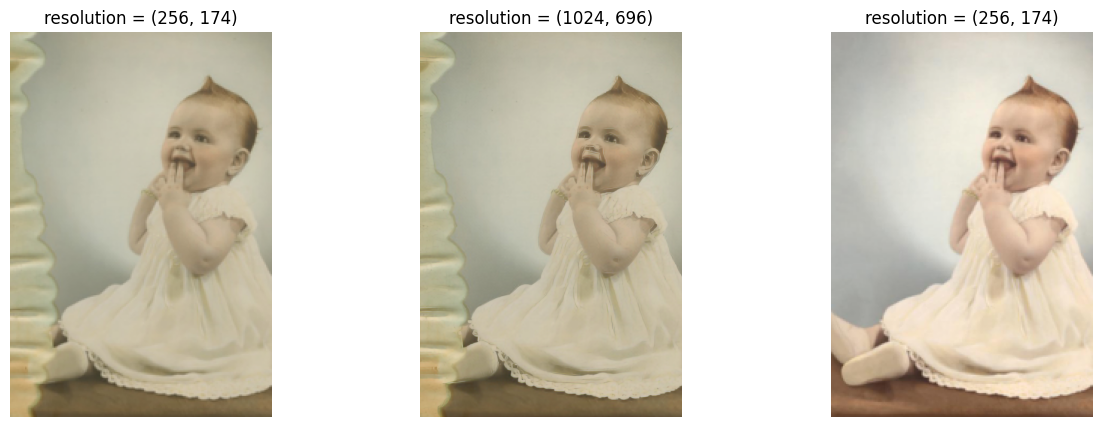

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plt.subplot(1,3,1)
plot_data.imshow(original.squeeze())
plt.title(f'resolution = ({original.shape[2]}, {original.shape[3]})')
plt.axis('off') 

plt.subplot(1,3,2)
plot_data.imshow(out.detach().squeeze())
plt.title(f'resolution = ({out.shape[2]}, {out.shape[3]})')
plt.axis('off') 

plt.subplot(1,3,3)
plot_data.imshow(restored.squeeze())
plt.title(f'resolution = ({restored.shape[2]}, {restored.shape[3]})')
plt.axis('off') 

In [10]:
rest = RestorationSubNet()

In [11]:
original.shape

torch.Size([1, 3, 256, 198])

In [12]:
out = rest(original)

torch.Size([1, 3, 256, 198])
torch.Size([1, 3, 64, 49])
torch.Size([1, 3, 32, 24])
-----
torch.Size([1, 3, 1024, 792])
torch.Size([1, 3, 256, 196])
torch.Size([1, 3, 128, 96])
-----
torch.Size([1, 3, 1024, 792])
torch.Size([1, 3, 1024, 784])
torch.Size([1, 3, 1024, 768])


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 792 but got size 784 for tensor number 1 in the list.

In [ ]:
out.shape

torch.Size([3, 3, 1024, 768])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


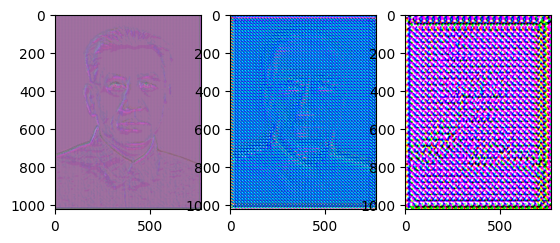

In [ ]:
plt.subplots(1,3)


for i, img in enumerate(out):
    plt.subplot(1,3,i+1)
    plt.imshow(img.detach().numpy().transpose(1,2,0))
